# MSCS 634 Project Deliverable 3

## Objective
The purpose of this deliverable is to build classification and clustering models, apply association rule mining, and perform hyperparameter tuning to improve model performance.
Here is the URL for the dataset: https://www.kaggle.com/datasets/anassarfraz13/student-success-factors-and-insights

Here are the classification models that have been implemented: Decision Trees, k-NN, Naïve Bayes.

Here are the clustering models that have been implemented: K-Means, Hierarchical.

# Re-using the Data Collection and Cleaning logic from Project Deliverable-1

This below logic:

 * Loads and cleans the dataset by handling missing values (mode/median), removing duplicates, and checking categorical data for inconsistencies.

 * Analyzes numerical columns to detect outliers using the IQR method and reports how many rows are affected.

 * Prepares the dataset for further analysis or modeling by ensuring data quality and identifying potential issues.

 * Even though outliers exist, we keep them because values like exam scores and hours studied are valid and useful for understanding differences between high and low performance.

In [152]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

df = pd.read_csv('StudentPerformanceFactors.csv')
print(df.head)
df.info()

df.describe()

#Hnadling missing values
print("Missing values in each column:")
print(df.isnull().sum())
print(f"\nTotal missing values: {df.isnull().sum().sum()}")


# Fixing the missing values
print("Before handling missing values:")
print(f"Shape: {df.shape}")

# Check which columns have missing values
cols_with_missing = df.columns[df.isnull().any()].tolist()
print(f"\nColumns with missing values: {cols_with_missing}")

# For categorical columns with missing values, filling with mode
# For numerical columns with missing values, filling with median
for col in cols_with_missing:
    if df[col].dtype in ['object']:
        mode_value = df[col].mode()[0] if not df[col].mode().empty else 'Unknown'
        df[col].fillna(mode_value, inplace=True)
        print(f"Filled {col} with mode: {mode_value}")
    else:
        median_value = df[col].median()
        df[col].fillna(median_value, inplace=True)
        print(f"Filled {col} with median: {median_value}")

print(f"\nAfter handling missing values:")
print(f"Shape: {df.shape}")
print(f"Remaining missing values: {df.isnull().sum().sum()}")

#Removing duplicates
print("Before removing duplicates:")
print(f"Shape: {df.shape}")

duplicate_count = df.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicate_count}")

if duplicate_count > 0:
    df = df.drop_duplicates()
    print("\nAfter removing duplicates:")
    print(f"Shape: {df.shape}")
    print(f"Rows removed: {duplicate_count}")
else:
    print("\nNo duplicates found in the dataset. Therefore not removing any date")


# Checking for inconsistent data in categorical columns
print("Unique values in categorical columns:\n")
categorical_cols = df.select_dtypes(include=['object']).columns

# Check for any inconsistencies in categorical data
inconsistencies_found = False
print("Checking for inconsistent categorical values...")
for col in categorical_cols:
    unique_vals = df[col].unique()
    # Check for leading/trailing spaces
    stripped_vals = [str(val).strip() if pd.notna(val) else val for val in unique_vals]
    original_vals = [str(val) if pd.notna(val) else val for val in unique_vals]
    
    if stripped_vals != original_vals:
        print(f"  WARNING: {col} has values with whitespace issues!")
        inconsistencies_found = True
    print(f"{col}: {unique_vals}\n")

if not inconsistencies_found:
    print("No inconsistencies found in categorical columns (no extra whitespace, all consistent)\n")


# Check for outliers using IQR method for numerical columns
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print("Outlier detection using IQR method:\n")

# Create mask with DataFrame index to ensure alignment
outlier_mask = pd.Series(False, index=df.index)

for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    print(f"{col}:")
    print(f"  Lower bound: {lower_bound:.2f}, Upper bound: {upper_bound:.2f}")
    print(f"  Number of outliers: {len(outliers)} ({len(outliers)/len(df)*100:.2f}%)")
    if len(outliers) > 0:
        print(f"  Outlier range: [{outliers[col].min():.2f}, {outliers[col].max():.2f}]")
        # Add to outlier mask
        outlier_mask |= (df[col] < lower_bound) | (df[col] > upper_bound)
    print()

# Summary of outliers found
total_outliers = outlier_mask.sum()
print(f"Total rows with at least one outlier: {total_outliers}")
print(f"Percentage of data with outliers: {total_outliers/len(df)*100:.2f}%")

# It doesnot make sense to remove most of the outliers in above case.
# This is because the rows like exam_scores and hours studied are all in valid range.
# It makes sense to keep those scores as they will help understand the factors responsible for excellent exam scores
# vs the poorest exam performances.


#We might have to rethink whether to remove the outliers or not based the analysis we need to perform for future deliverables.
#For now we will create another df_cleaned with the outliers removed
# df_cleaned = df[~outlier_mask].reset_index(drop=True)

# print(f"\nAfter outlier removal:")
# print(f"  Rows before: {len(df)}")
# # print(f"  Rows after: {len(df_cleaned)}")
# print(f"  Removed: {total_outliers} rows ({total_outliers/len(df)*100:.2f}%)")

# df.info()

    

<bound method NDFrame.head of       Hours_Studied  Attendance Parental_Involvement Access_to_Resources  \
0                23          84                  Low                High   
1                19          64                  Low              Medium   
2                24          98               Medium              Medium   
3                29          89                  Low              Medium   
4                19          92               Medium              Medium   
...             ...         ...                  ...                 ...   
6602             25          69                 High              Medium   
6603             23          76                 High              Medium   
6604             20          90               Medium                 Low   
6605             10          86                 High                High   
6606             15          67               Medium                 Low   

     Extracurricular_Activities  Sleep_Hours  Previous_Sc

## Part 1: Classification Models

In this section, we will:
1. Prepare the data for classification by creating a target variable from Exam_Score
2. Build three classification models (Decision Tree, k-NN, Naive Bayes)
3. Perform hyperparameter tuning
4. Evaluate models using confusion matrix, ROC curve, and accuracy/F1 scores


In [153]:
# Data Preparation for Classification
# Create a binary target variable based on Exam_Score
# We'll classify students as "High" (>=70) or "Low" (<70) performance
# 70+ is a B or above grade which is reasonable for students performance grouping.

# Creating target variable using this logic.
df['Performance'] = df['Exam_Score'].apply(lambda x: 'High' if x >= 70 else 'Low')
print("Target variable distribution:")
print(df['Performance'].value_counts())
print(f"\nHigh Performance: {(df['Performance'] == 'High').sum() / len(df) * 100:.2f}%")
print(f"Low Performance: {(df['Performance'] == 'Low').sum() / len(df) * 100:.2f}%")

# Separate features and target
# Exclude Exam_Score and Performance from features
feature_cols = [col for col in df.columns if col not in ['Exam_Score', 'Performance']]
X = df[feature_cols]
y = df['Performance']

print(f"\nNumber of features: {len(feature_cols)}")
print(f"Feature columns: {feature_cols}")


Target variable distribution:
Performance
Low     4982
High    1625
Name: count, dtype: int64

High Performance: 24.60%
Low Performance: 75.40%

Number of features: 19
Feature columns: ['Hours_Studied', 'Attendance', 'Parental_Involvement', 'Access_to_Resources', 'Extracurricular_Activities', 'Sleep_Hours', 'Previous_Scores', 'Motivation_Level', 'Internet_Access', 'Tutoring_Sessions', 'Family_Income', 'Teacher_Quality', 'School_Type', 'Peer_Influence', 'Physical_Activity', 'Learning_Disabilities', 'Parental_Education_Level', 'Distance_from_Home', 'Gender']


### Preprocessing
In this preprocessing block, we prepare the dataset for machine learning by handling both numerical and categorical features. First, we identify which columns are numerical and which are categorical. Numerical features are standardized using StandardScaler to ensure they share a similar scale, which helps many algorithms perform better. Categorical variables are transformed using OneHotEncoder, converting them into binary indicator columns while dropping the first category to avoid multicollinearity. These transformations are combined into a ColumnTransformer so that both types of data can be processed in a single pipeline. The transformed feature matrix is then generated, and the corresponding feature names are extracted. Next, the target variable is encoded using LabelEncoder to convert class labels into numeric values suitable for modeling. Finally, the processed dataset is split into training and testing sets using an 80/20 ratio with stratification to preserve class balance.

In [154]:
# Preprocessing: Encode categorical variables and scale numerical features
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Identify numerical and categorical columns
numerical_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print(f"Numerical features: {numerical_features}")
print(f"Categorical features: {categorical_features}")

# Creating preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ],
    remainder='passthrough'
)

# Transform features
X_processed = preprocessor.fit_transform(X)
feature_names = (numerical_features + 
                list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)))

print(f"\nProcessed feature shape: {X_processed.shape}")
print(f"Number of features after encoding: {len(feature_names)}")

# Encode target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
print(f"\nTarget encoding: {dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))}")

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")


Numerical features: ['Hours_Studied', 'Attendance', 'Sleep_Hours', 'Previous_Scores', 'Tutoring_Sessions', 'Physical_Activity']
Categorical features: ['Parental_Involvement', 'Access_to_Resources', 'Extracurricular_Activities', 'Motivation_Level', 'Internet_Access', 'Family_Income', 'Teacher_Quality', 'School_Type', 'Peer_Influence', 'Learning_Disabilities', 'Parental_Education_Level', 'Distance_from_Home', 'Gender']

Processed feature shape: (6607, 27)
Number of features after encoding: 27

Target encoding: {'High': np.int64(0), 'Low': np.int64(1)}

Training set size: 5285
Test set size: 1322


### Model Training and Performance evaluation(Decision Trees, k-NN, Naïve Bayes)
This block imports key classification models and evaluation metrics, then initializes Decision Tree, k-NN, and Naive Bayes classifiers. Each model is trained on the training set, used to generate predictions, and evaluated using accuracy, F1-score, and a full classification report. The results, including predictions and confusion matrices, are stored for later comparison.

In [155]:
# Import classification models and metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (confusion_matrix, classification_report, accuracy_score, 
                            f1_score, roc_curve, auc, roc_auc_score)
from sklearn.model_selection import GridSearchCV

# Initialize models
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'k-NN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB()
}

# Train and evaluate each model
results = {}

#For each model printing the results here:
for name, model in models.items():
    print(f"For the model type: {name}...")
    print(f"{'-'*60}")
    
    # Train model
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"\n{name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
    
    # Store results
    results[name] = {
        'model': model,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'accuracy': accuracy,
        'f1': f1,
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }


For the model type: Decision Tree...
------------------------------------------------------------

Decision Tree Results:
Accuracy: 0.8570
F1 Score: 0.9041

Classification Report:
              precision    recall  f1-score   support

        High       0.70      0.74      0.72       325
         Low       0.91      0.89      0.90       997

    accuracy                           0.86      1322
   macro avg       0.81      0.82      0.81      1322
weighted avg       0.86      0.86      0.86      1322

For the model type: k-NN...
------------------------------------------------------------

k-NN Results:
Accuracy: 0.8865
F1 Score: 0.9268

Classification Report:
              precision    recall  f1-score   support

        High       0.83      0.68      0.75       325
         Low       0.90      0.95      0.93       997

    accuracy                           0.89      1322
   macro avg       0.86      0.82      0.84      1322
weighted avg       0.88      0.89      0.88      1322

For 

### Model's Result
Across the three models tested, Naive Bayes achieved the highest overall accuracy (0.8964) and F1 score (0.9329), showing strong performance, especially in correctly identifying the "Low" class. The k-NN model also performed well with an accuracy of 0.8865 and an F1 score of 0.9268, though its recall for the "High" class was lower. The Decision Tree model had the lowest accuracy (0.8570) and struggled more with precision and recall for the "High" category compared to the others. Overall, both k-NN and Naive Bayes outperformed the Decision Tree, with Naive Bayes being the best-performing model in this evaluation.

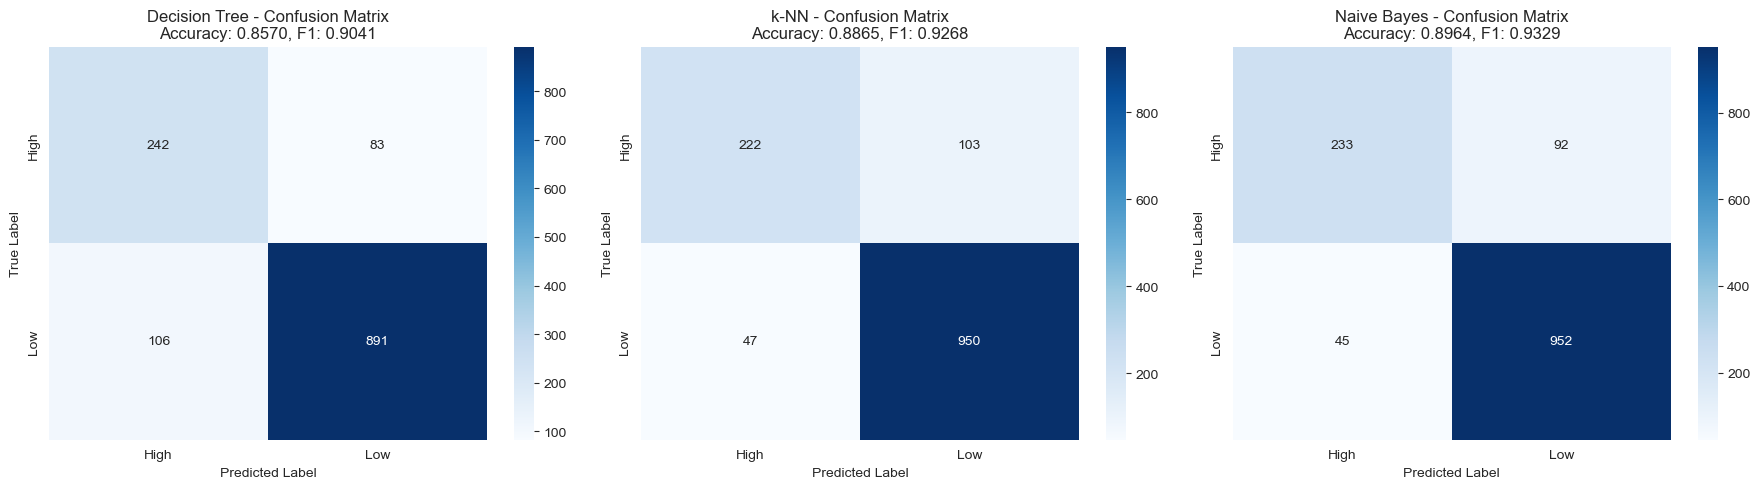

In [156]:
# Visualizing Confusion Matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (name, result) in enumerate(results.items()):
    cm = result['confusion_matrix']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    axes[idx].set_title(f'{name} - Confusion Matrix\nAccuracy: {result["accuracy"]:.4f}, F1: {result["f1"]:.4f}')
    axes[idx].set_ylabel('True Label')
    axes[idx].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()


### ROC Curve
Here, ROC (Receiver Operating Characteristic) curve is used to evaluate a classifier’s performance by plotting the true positive rate (recall) against the false positive rate across different thresholds. It visually shows the trade-off between correctly identifying positive cases and incorrectly labeling negatives as positives. The closer the curve is to the top-left corner, the better the model’s performance. Additionally, the Area Under the Curve (AUC) provides a single value summarizing the model’s ability to discriminate between classes, with higher values indicating better performance. ROC curves are commonly used to compare multiple models and select the one with the best balance of sensitivity and specificity.

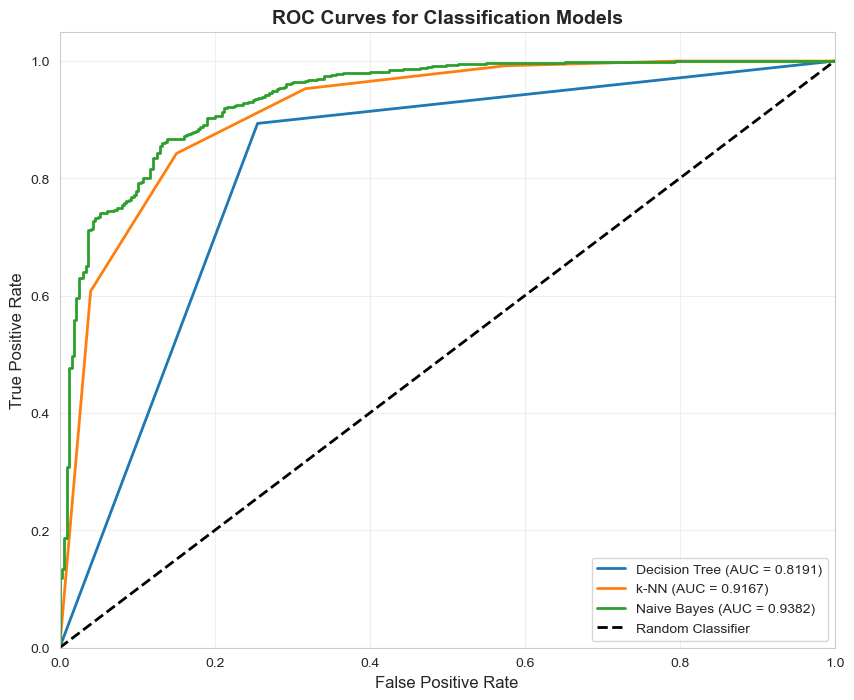

In [157]:
# Plot ROC Curves
plt.figure(figsize=(10, 8))

for name, result in results.items():
    if result['y_pred_proba'] is not None:
        fpr, tpr, _ = roc_curve(y_test, result['y_pred_proba'])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.4f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves for Classification Models', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(alpha=0.3)
plt.show()


### Hyperparameter Tuning(Naive Bayes)

I have performed hyperparameter tuning for the Naive Bayes classifier using GridSearchCV. Since Naive Bayes showed the best performance among the three models (Accuracy: 0.8964, F1: 0.9329), it makes sense to optimize its hyperparameters to potentially achieve even better results.

This below block performs hyperparameter tuning for the Naive Bayes classifier by testing 100 different values of the var_smoothing parameter using 5-fold cross-validation, resulting in 500 model fits. The best parameter value was identified as 0.0811, which produced a cross-validated F1 score of 0.9494. When evaluated on the test set, the tuned Naive Bayes model achieved higher performance, with an accuracy of 0.9281 and an F1 score of 0.9536, compared to the original model’s 0.8964 accuracy and 0.9329 F1. This tuning led to noticeable improvements in both F1 score (0.0208) and accuracy (0.0318), demonstrating the effectiveness of hyperparameter optimization.


In [179]:
# Hyperparameter Tuning for Naive Bayes
print("Performing Hyperparameter Tuning for Naive Bayes...")
print("-"*60)

# Define parameter grid for GaussianNB
# The main hyperparameter for GaussianNB is var_smoothing
# It adds a small value to the variance to prevent numerical instability
# We'll test a range of values on a log scale
param_grid = {
    'var_smoothing': np.logspace(0, -9, num=100)  # Range from 1e0 to 1e-9
}

# Create base model
nb_base = GaussianNB()

# GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(
    nb_base, 
    param_grid, 
    cv=5, 
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Best parameters
print(f"\nBest Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation F1 Score: {grid_search.best_score_:.4f}")

# Evaluate best model on test set
best_nb = grid_search.best_estimator_
y_pred_tuned = best_nb.predict(X_test)
y_pred_proba_tuned = best_nb.predict_proba(X_test)[:, 1]

accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
f1_tuned = f1_score(y_test, y_pred_tuned)

print(f"\nTuned Naive Bayes - Test Set Performance:")
print(f"Accuracy: {accuracy_tuned:.4f}")
print(f"F1 Score: {f1_tuned:.4f}")

# Compare with original
print(f"\nComparison:")
print(f"Original Naive Bayes - Accuracy: {results['Naive Bayes']['accuracy']:.4f}, F1: {results['Naive Bayes']['f1']:.4f}")
print(f"Tuned Naive Bayes   - Accuracy: {accuracy_tuned:.4f}, F1: {f1_tuned:.4f}")
print(f"Improvement in F1: {(f1_tuned - results['Naive Bayes']['f1']):.4f}")
print(f"Improvement in Accuracy: {(accuracy_tuned - results['Naive Bayes']['accuracy']):.4f}")

# Update results
results['Naive Bayes (Tuned)'] = {
    'model': best_nb,
    'y_pred': y_pred_tuned,
    'y_pred_proba': y_pred_proba_tuned,
    'accuracy': accuracy_tuned,
    'f1': f1_tuned,
    'confusion_matrix': confusion_matrix(y_test, y_pred_tuned)
}


Performing Hyperparameter Tuning for Naive Bayes...
------------------------------------------------------------
Fitting 5 folds for each of 100 candidates, totalling 500 fits

Best Parameters: {'var_smoothing': np.float64(0.08111308307896872)}
Best Cross-Validation F1 Score: 0.9494

Tuned Naive Bayes - Test Set Performance:
Accuracy: 0.9281
F1 Score: 0.9536

Comparison:
Original Naive Bayes - Accuracy: 0.8964, F1: 0.9329
Tuned Naive Bayes   - Accuracy: 0.9281, F1: 0.9536
Improvement in F1: 0.0208
Improvement in Accuracy: 0.0318


## Part 2: Clustering Models

In this section, we will:
1. Prepare data for clustering
2. Build K-Means and Hierarchical clustering models
3. Visualize clustering results
4. Analyze and explain the identified groups


In [159]:
# Prepare data for clustering
# Use numerical features and encode categorical features
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist

# Prepare clustering dataset (use all features)
X_cluster = preprocessor.fit_transform(X)

print(f"Clustering dataset shape: {X_cluster.shape}")
print(f"Features used for clustering: {len(feature_names)}")


Clustering dataset shape: (6607, 27)
Features used for clustering: 27


Evaluating optimal number of clusters...
K=2: Inertia=62971.27, Silhouette=0.0717
K=3: Inertia=59808.72, Silhouette=0.0660
K=4: Inertia=57284.36, Silhouette=0.0616
K=5: Inertia=55340.31, Silhouette=0.0616
K=6: Inertia=53748.93, Silhouette=0.0600
K=7: Inertia=52450.59, Silhouette=0.0589
K=8: Inertia=51411.67, Silhouette=0.0571
K=9: Inertia=50523.90, Silhouette=0.0570
K=10: Inertia=49682.91, Silhouette=0.0565


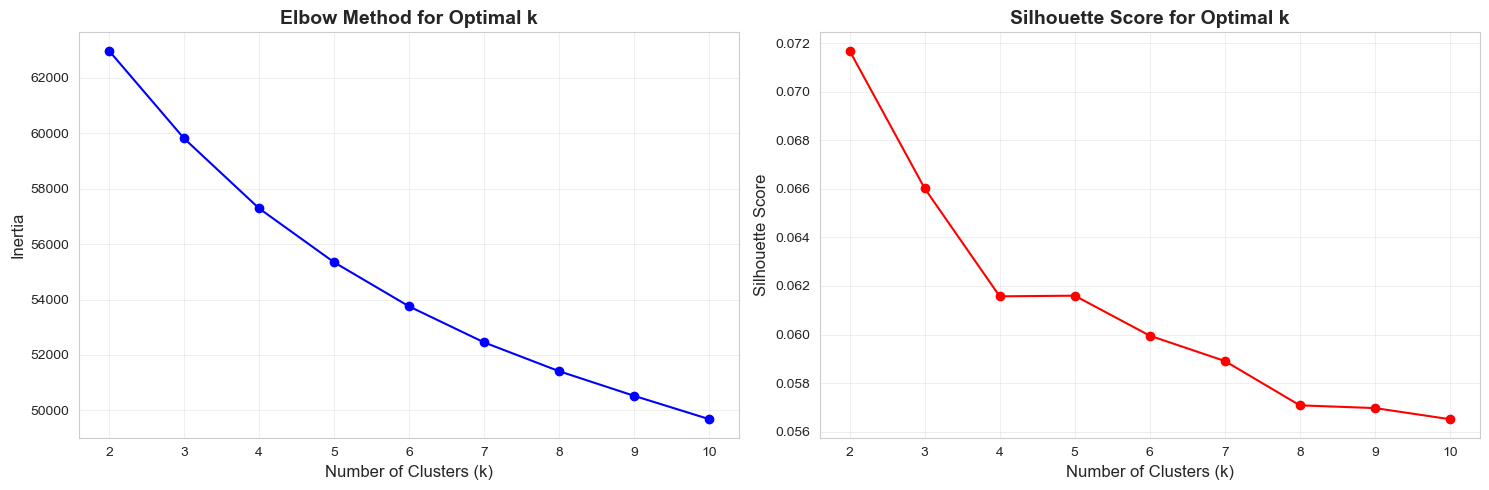


Optimal number of clusters (based on Silhouette Score): 2


In [160]:
# Determining optimal number of clusters using Elbow Method and Silhouette Score
inertias = []
silhouette_scores = []
K_range = range(2, 11)

print("Evaluating optimal number of clusters...")
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_cluster)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_cluster, kmeans.labels_))
    print(f"K={k}: Inertia={kmeans.inertia_:.2f}, Silhouette={silhouette_scores[-1]:.4f}")

# Plot Elbow Method and Silhouette Score
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Elbow Method
ax1.plot(K_range, inertias, 'bo-')
ax1.set_xlabel('Number of Clusters (k)', fontsize=12)
ax1.set_ylabel('Inertia', fontsize=12)
ax1.set_title('Elbow Method for Optimal k', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Silhouette Score
ax2.plot(K_range, silhouette_scores, 'ro-')
ax2.set_xlabel('Number of Clusters (k)', fontsize=12)
ax2.set_ylabel('Silhouette Score', fontsize=12)
ax2.set_title('Silhouette Score for Optimal k', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find optimal k (highest silhouette score)
optimal_k = K_range[np.argmax(silhouette_scores)]
print(f"\nOptimal number of clusters (based on Silhouette Score): {optimal_k}")


In [161]:
# K-Means Clustering
print("K-Means Clustering")
print("-"*60)

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_cluster)

# Add cluster labels to dataframe
df['KMeans_Cluster'] = kmeans_labels

# Evaluate clustering
kmeans_silhouette = silhouette_score(X_cluster, kmeans_labels)
kmeans_db = davies_bouldin_score(X_cluster, kmeans_labels)

print(f"Number of clusters: {optimal_k}")
print(f"Silhouette Score: {kmeans_silhouette:.4f}")
print(f"Davies-Bouldin Index: {kmeans_db:.4f}")

# Cluster distribution
print(f"\nCluster Distribution:")
for i in range(optimal_k):
    count = np.sum(kmeans_labels == i)
    print(f"Cluster {i}: {count} students ({count/len(df)*100:.2f}%)")


K-Means Clustering
------------------------------------------------------------
Number of clusters: 2
Silhouette Score: 0.0717
Davies-Bouldin Index: 3.5091

Cluster Distribution:
Cluster 0: 3354 students (50.76%)
Cluster 1: 3253 students (49.24%)


In [162]:
# Hierarchical Clustering
print("Hierarchical Clustering")
print("-"*60)

hierarchical = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
hierarchical_labels = hierarchical.fit_predict(X_cluster)

# Add cluster labels to dataframe
df['Hierarchical_Cluster'] = hierarchical_labels

# Evaluate clustering
hierarchical_silhouette = silhouette_score(X_cluster, hierarchical_labels)
hierarchical_db = davies_bouldin_score(X_cluster, hierarchical_labels)

print(f"Number of clusters: {optimal_k}")
print(f"Silhouette Score: {hierarchical_silhouette:.4f}")
print(f"Davies-Bouldin Index: {hierarchical_db:.4f} (lower is better)")

# Cluster distribution
print(f"\nCluster Distribution:")
for i in range(optimal_k):
    count = np.sum(hierarchical_labels == i)
    print(f"Cluster {i}: {count} students ({count/len(df)*100:.2f}%)")


Hierarchical Clustering
------------------------------------------------------------
Number of clusters: 2
Silhouette Score: 0.0408
Davies-Bouldin Index: 4.7368 (lower is better)

Cluster Distribution:
Cluster 0: 3347 students (50.66%)
Cluster 1: 3260 students (49.34%)


PCA explained variance ratio: [0.10214236 0.09993856]
Total variance explained: 0.2021


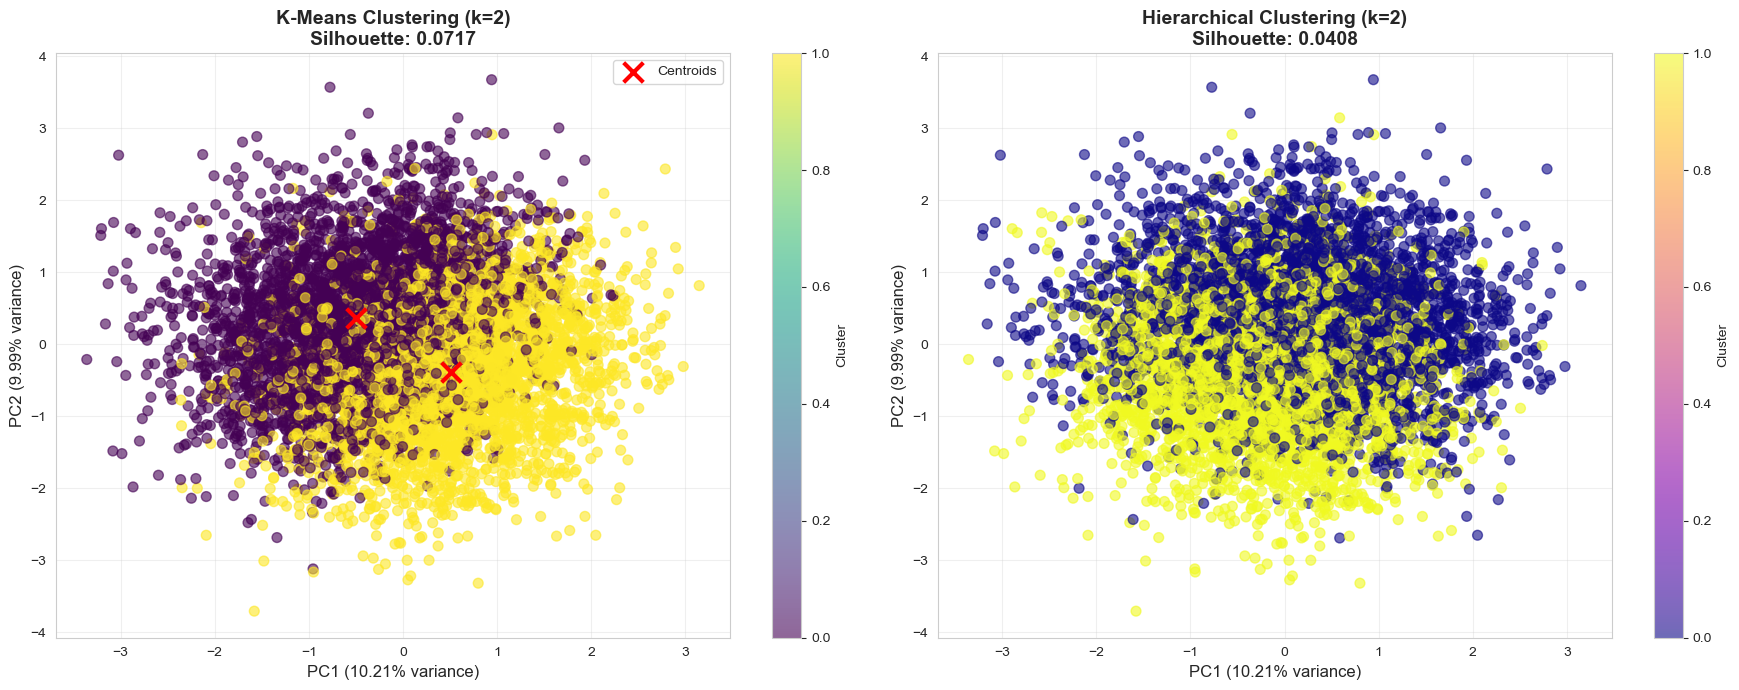

In [163]:
# Visualize Clusters using PCA for dimensionality reduction
from sklearn.decomposition import PCA

# Apply PCA to reduce to 2D for visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_cluster)

print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total variance explained: {pca.explained_variance_ratio_.sum():.4f}")

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# K-Means visualization
scatter1 = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, 
                          cmap='viridis', alpha=0.6, s=50)
# Transform cluster centers to PCA space
centers_pca = pca.transform(kmeans.cluster_centers_)
axes[0].scatter(centers_pca[:, 0], centers_pca[:, 1],
                c='red', marker='x', s=200, linewidths=3, label='Centroids')
axes[0].set_title(f'K-Means Clustering (k={optimal_k})\nSilhouette: {kmeans_silhouette:.4f}', 
                 fontsize=14, fontweight='bold')
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)', fontsize=12)
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Hierarchical visualization
scatter2 = axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=hierarchical_labels, 
                          cmap='plasma', alpha=0.6, s=50)
axes[1].set_title(f'Hierarchical Clustering (k={optimal_k})\nSilhouette: {hierarchical_silhouette:.4f}', 
                 fontsize=14, fontweight='bold')
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)', fontsize=12)
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)', fontsize=12)
axes[1].grid(True, alpha=0.3)

plt.colorbar(scatter1, ax=axes[0], label='Cluster')
plt.colorbar(scatter2, ax=axes[1], label='Cluster')
plt.tight_layout()
plt.show()


### Visualization for Hierarchical Clustering

Creating dendrogram with 100 samples...


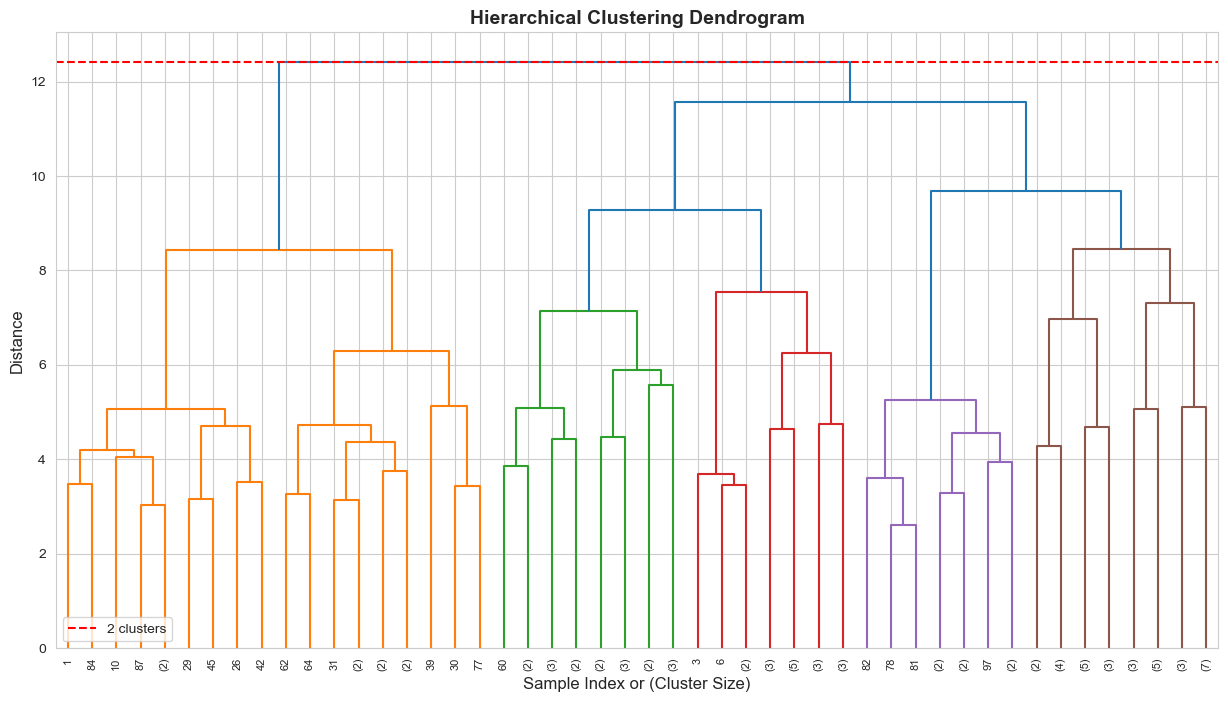

In [164]:
# Visualizing Hierarchical Clustering Dendrogram
# Using a sample for dendrogram visualization (full dataset is too large)
sample_size = min(100, len(X_cluster))
sample_indices = np.random.choice(len(X_cluster), sample_size, replace=False)
X_sample = X_cluster[sample_indices]

print(f"Creating dendrogram with {sample_size} samples...")
linkage_matrix = linkage(X_sample, method='ward')

plt.figure(figsize=(15, 8))
dendrogram(linkage_matrix, truncate_mode='level', p=5)
plt.title('Hierarchical Clustering Dendrogram', fontsize=14, fontweight='bold')
plt.xlabel('Sample Index or (Cluster Size)', fontsize=12)
plt.ylabel('Distance', fontsize=12)
plt.axhline(y=linkage_matrix[-optimal_k+1, 2], color='r', linestyle='--', 
            label=f'{optimal_k} clusters')
plt.legend()
plt.show()


### Hierarchical Clustering: Feature Comparison Heatmap

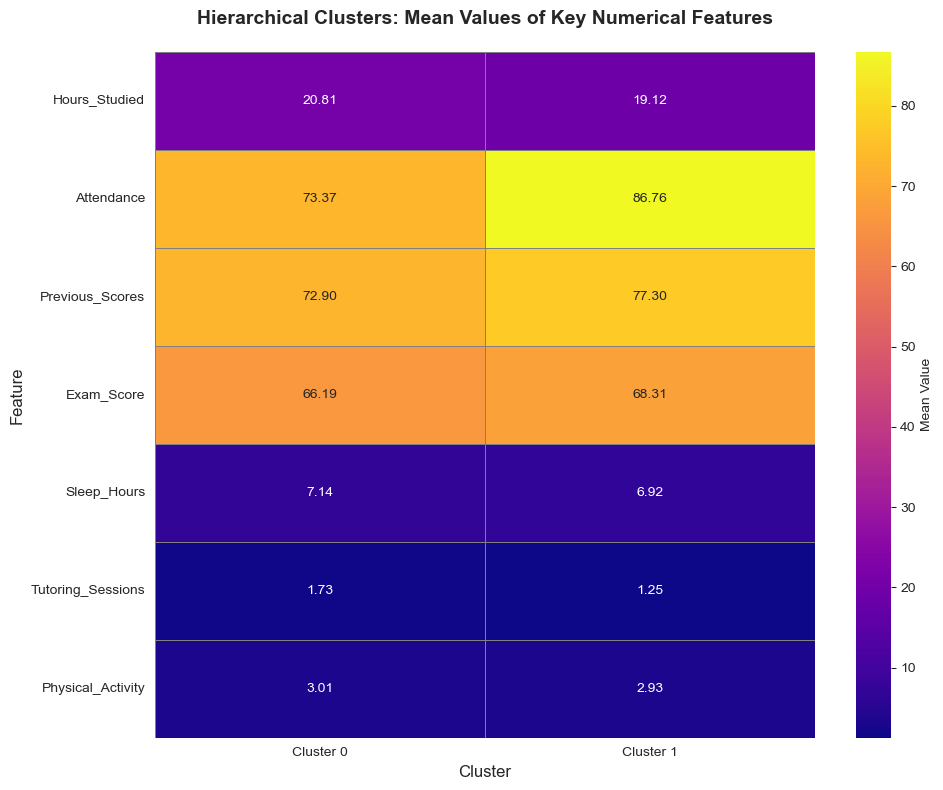

In [165]:
key_numerical_features = ['Hours_Studied', 'Attendance', 'Previous_Scores', 'Exam_Score', 
                          'Sleep_Hours', 'Tutoring_Sessions', 'Physical_Activity']

# Calculate mean values for each hierarchical cluster
hierarchical_cluster_means = pd.DataFrame()
for cluster_id in range(optimal_k):
    cluster_data = df[df['Hierarchical_Cluster'] == cluster_id]
    hierarchical_cluster_means[f'Cluster {cluster_id}'] = cluster_data[key_numerical_features].mean()

hierarchical_cluster_means.index = key_numerical_features

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(hierarchical_cluster_means, annot=True, fmt='.2f', cmap='plasma', 
            cbar_kws={'label': 'Mean Value'}, linewidths=0.5, linecolor='gray')
plt.title('Hierarchical Clusters: Mean Values of Key Numerical Features', 
         fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()


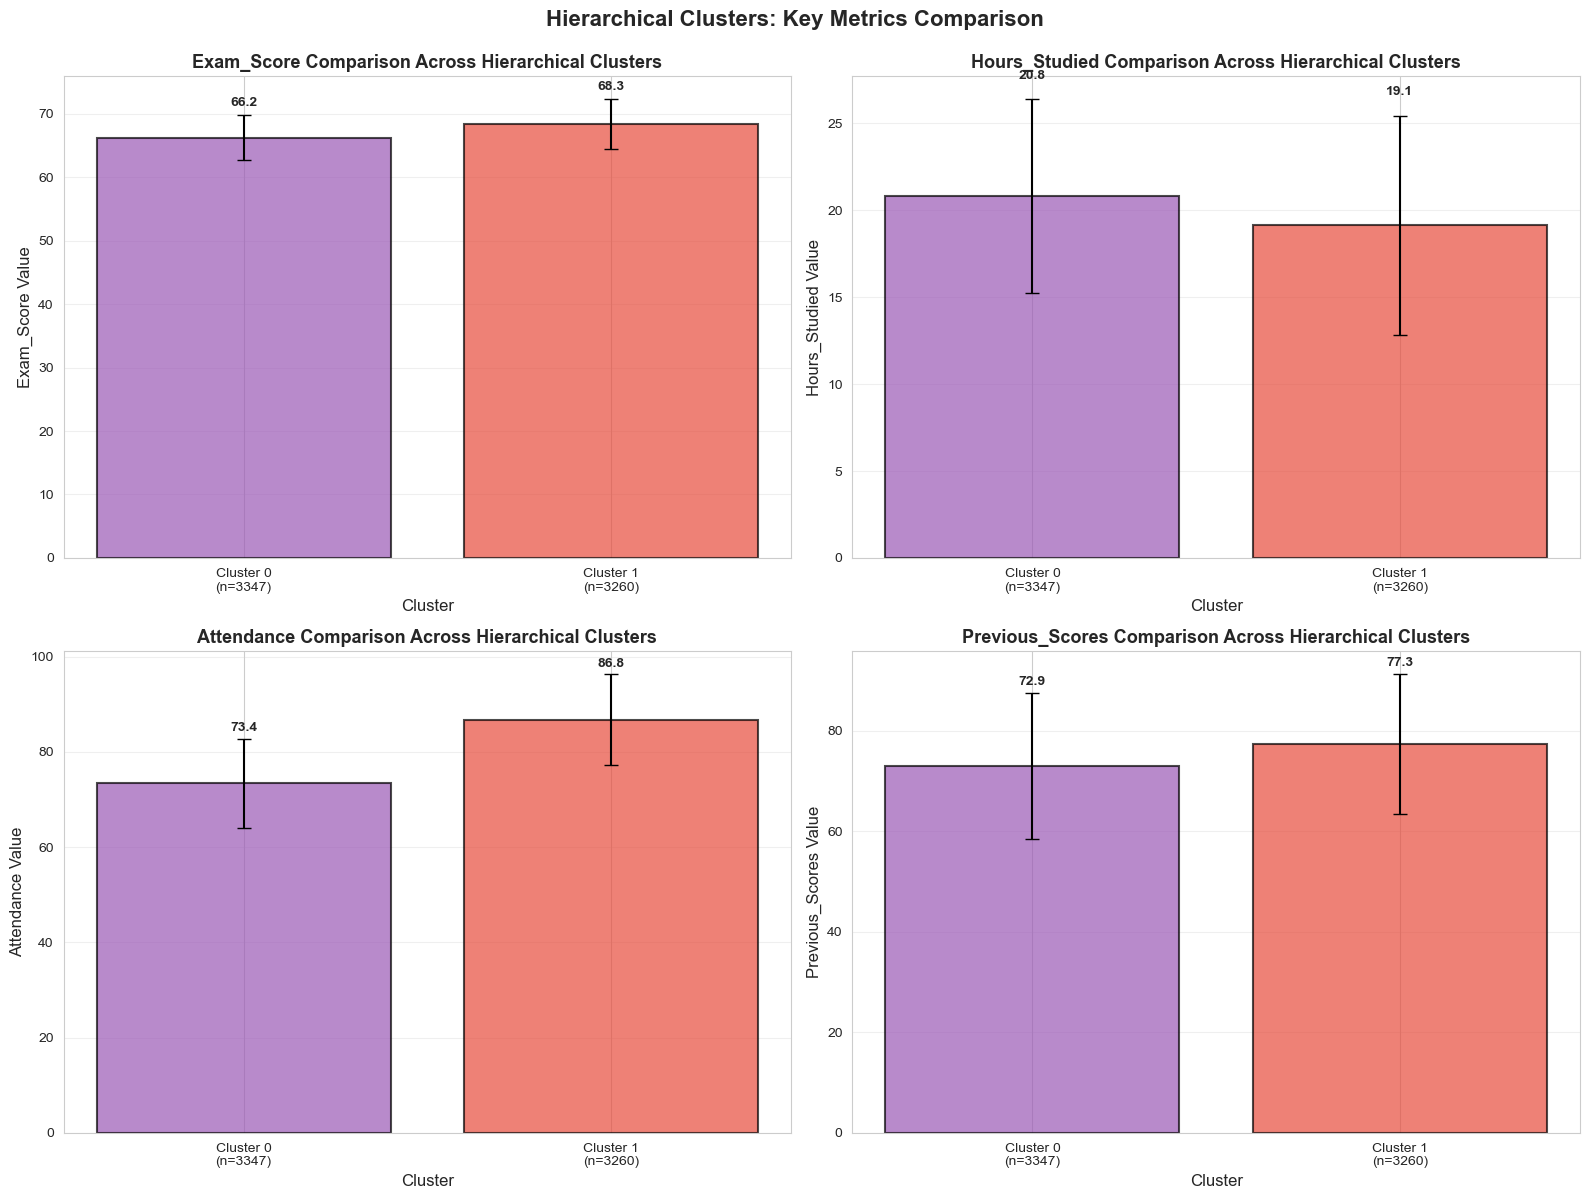

In [166]:
# Hierarchical Clustering: Side-by-Side Comparison of Key Metrics
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Prepare data for comparison
comparison_features = ['Exam_Score', 'Hours_Studied', 'Attendance', 'Previous_Scores']
colors_list = ['#9b59b6', '#e74c3c', '#3498db', '#2ecc71']

for idx, feature in enumerate(comparison_features):
    ax = axes[idx // 2, idx % 2]
    
    # Calculate means and std for each hierarchical cluster
    cluster_stats = []
    cluster_labels = []
    for cluster_id in range(optimal_k):
        cluster_data = df[df['Hierarchical_Cluster'] == cluster_id][feature]
        cluster_stats.append({
            'mean': cluster_data.mean(),
            'std': cluster_data.std(),
            'min': cluster_data.min(),
            'max': cluster_data.max()
        })
        cluster_labels.append(f'Cluster {cluster_id}\n(n={len(cluster_data)})')
    
    # Create grouped bar chart
    x = np.arange(optimal_k)
    means = [stat['mean'] for stat in cluster_stats]
    stds = [stat['std'] for stat in cluster_stats]
    
    bars = ax.bar(x, means, yerr=stds, capsize=5, alpha=0.7, 
                  color=colors_list[:optimal_k], edgecolor='black', linewidth=1.5)
    ax.set_xlabel('Cluster', fontsize=12)
    ax.set_ylabel(f'{feature} Value', fontsize=12)
    ax.set_title(f'{feature} Comparison Across Hierarchical Clusters', fontsize=13, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(cluster_labels)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for i, (bar, mean_val) in enumerate(zip(bars, means)):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + stds[i] + 1,
               f'{mean_val:.1f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.suptitle('Hierarchical Clusters: Key Metrics Comparison', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()


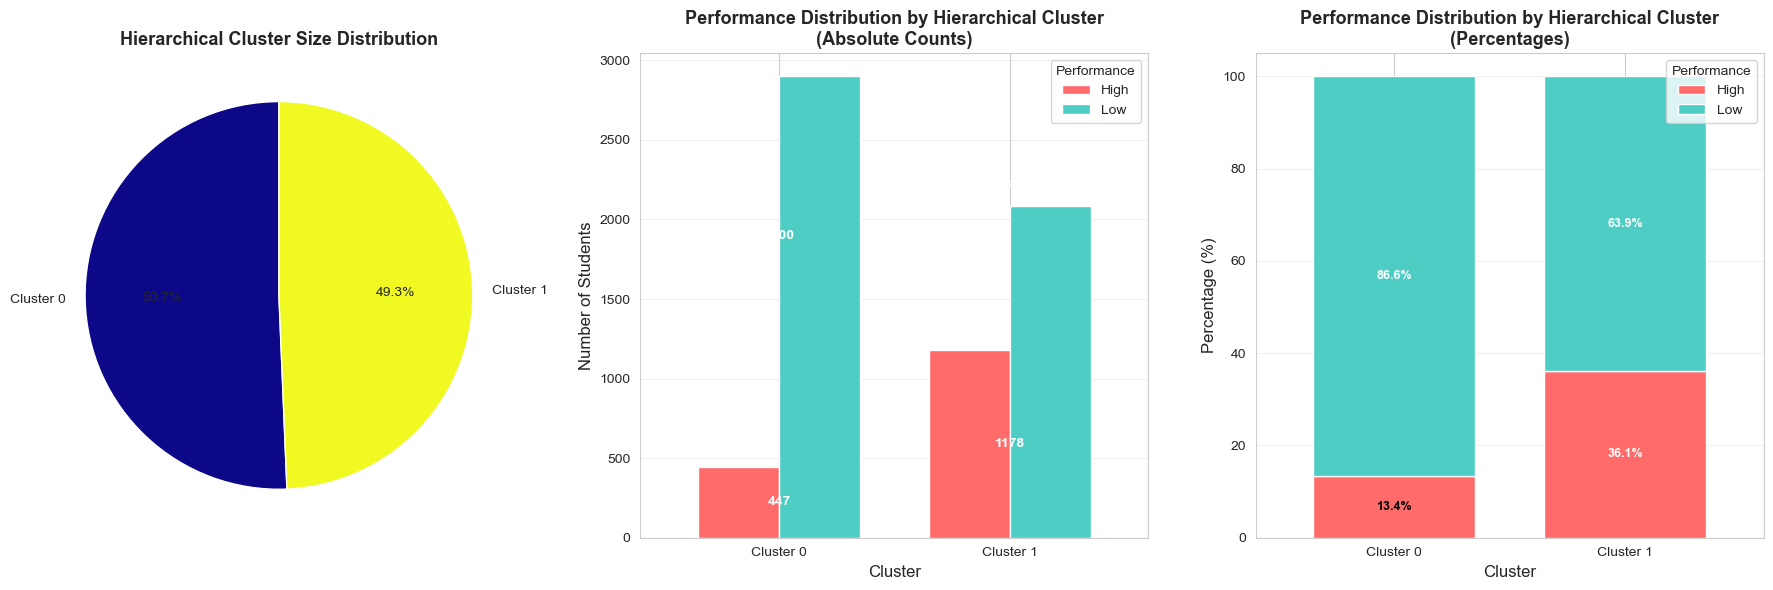

In [167]:
# Hierarchical Clustering: Cluster Size Distribution and Performance Comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1. Cluster Size Distribution (Pie Chart)
hierarchical_cluster_counts = df['Hierarchical_Cluster'].value_counts().sort_index()
colors_hier = plt.cm.plasma(np.linspace(0, 1, optimal_k))
axes[0].pie(hierarchical_cluster_counts.values, 
            labels=[f'Cluster {i}' for i in hierarchical_cluster_counts.index], 
            autopct='%1.1f%%', colors=colors_hier, startangle=90)
axes[0].set_title('Hierarchical Cluster Size Distribution', fontsize=13, fontweight='bold')

# 2. Performance Distribution (Absolute Counts)
performance_hier_crosstab = pd.crosstab(df['Hierarchical_Cluster'], df['Performance'])
performance_hier_crosstab.plot(kind='bar', ax=axes[1], color=['#ff6b6b', '#4ecdc4'], width=0.7)
axes[1].set_title('Performance Distribution by Hierarchical Cluster\n(Absolute Counts)', 
                 fontsize=13, fontweight='bold')
axes[1].set_xlabel('Cluster', fontsize=12)
axes[1].set_ylabel('Number of Students', fontsize=12)
axes[1].set_xticklabels([f'Cluster {i}' for i in range(optimal_k)], rotation=0)
axes[1].legend(title='Performance', fontsize=10)
axes[1].grid(True, alpha=0.3, axis='y')

# Add value labels
for i in range(optimal_k):
    for j, perf in enumerate(['High', 'Low']):
        value = performance_hier_crosstab.loc[i, perf]
        axes[1].text(i, value/2 if j == 0 else performance_hier_crosstab.loc[i, 'High'] + value/2,
                    f'{value}', ha='center', va='center', fontsize=10, fontweight='bold',
                    color='white' if value > 100 else 'black')

# 3. Performance Distribution (Percentages)
performance_hier_crosstab_pct = pd.crosstab(df['Hierarchical_Cluster'], df['Performance'], normalize='index') * 100
performance_hier_crosstab_pct.plot(kind='bar', stacked=True, ax=axes[2], 
                                   color=['#ff6b6b', '#4ecdc4'], width=0.7)
axes[2].set_title('Performance Distribution by Hierarchical Cluster\n(Percentages)', 
                 fontsize=13, fontweight='bold')
axes[2].set_xlabel('Cluster', fontsize=12)
axes[2].set_ylabel('Percentage (%)', fontsize=12)
axes[2].set_xticklabels([f'Cluster {i}' for i in range(optimal_k)], rotation=0)
axes[2].legend(title='Performance', fontsize=10)
axes[2].grid(True, alpha=0.3, axis='y')

# Add percentage labels
for i in range(optimal_k):
    y_pos = 0
    for j, perf in enumerate(['High', 'Low']):
        pct = performance_hier_crosstab_pct.loc[i, perf]
        if pct > 5:  # Only label if percentage is significant
            axes[2].text(i, y_pos + pct/2, f'{pct:.1f}%', 
                        ha='center', va='center', fontsize=9, fontweight='bold',
                        color='white' if pct > 30 else 'black')
        y_pos += pct

plt.tight_layout()
plt.show()


### Analysis and Visualization of K-Means Clustering

In [168]:
# Analyzing cluster characteristics
print("K-Means Cluster Analysis")
print("-"*60)

# Key features to analyze
key_features = ['Hours_Studied', 'Attendance', 'Previous_Scores', 'Exam_Score', 
                'Sleep_Hours', 'Tutoring_Sessions', 'Physical_Activity']

for cluster_id in range(optimal_k):
    cluster_data = df[df['KMeans_Cluster'] == cluster_id]
    print(f"\n--- Cluster {cluster_id} ({len(cluster_data)} students) ---")
    
    # Numerical features
    print("\nNumerical Features (Mean):")
    for feat in key_features:
        if feat in df.columns:
            print(f"  {feat}: {cluster_data[feat].mean():.2f}")
    
    # Categorical features
    print("\nCategorical Features (Mode):")
    cat_features = ['Parental_Involvement', 'Motivation_Level', 'Access_to_Resources', 
                    'Family_Income', 'Teacher_Quality', 'School_Type']
    for feat in cat_features:
        if feat in df.columns:
            mode_val = cluster_data[feat].mode()[0] if not cluster_data[feat].mode().empty else 'N/A'
            mode_pct = (cluster_data[feat] == mode_val).sum() / len(cluster_data) * 100
            print(f"  {feat}: {mode_val} ({mode_pct:.1f}%)")
    
    print(f"\nAverage Exam Score: {cluster_data['Exam_Score'].mean():.2f}")
    print(f"Performance Distribution:")
    if 'Performance' in df.columns:
        print(cluster_data['Performance'].value_counts().to_dict())


K-Means Cluster Analysis
------------------------------------------------------------

--- Cluster 0 (3354 students) ---

Numerical Features (Mean):
  Hours_Studied: 19.67
  Attendance: 80.81
  Previous_Scores: 62.87
  Exam_Score: 66.74
  Sleep_Hours: 7.09
  Tutoring_Sessions: 1.54
  Physical_Activity: 3.02

Categorical Features (Mode):
  Parental_Involvement: Medium (51.3%)
  Motivation_Level: Medium (50.8%)
  Access_to_Resources: Medium (49.6%)
  Family_Income: Low (40.4%)
  Teacher_Quality: Medium (61.5%)
  School_Type: Public (68.8%)

Average Exam Score: 66.74
Performance Distribution:
{'Low': 2683, 'High': 671}

--- Cluster 1 (3253 students) ---

Numerical Features (Mean):
  Hours_Studied: 20.29
  Attendance: 79.12
  Previous_Scores: 87.65
  Exam_Score: 67.75
  Sleep_Hours: 6.96
  Tutoring_Sessions: 1.44
  Physical_Activity: 2.92

Categorical Features (Mode):
  Parental_Involvement: Medium (50.4%)
  Motivation_Level: Medium (50.6%)
  Access_to_Resources: Medium (50.9%)
  Family_In

### Insights based on cluster results
The K-Means clustering reveals two student groups with slightly different characteristics and exam performance. Cluster 0, with 3,354 students, has lower previous scores and slightly fewer study hours, resulting in a lower average exam score (66.74) and a higher proportion of low-performing students. Cluster 1, with 3,253 students, shows higher previous scores and marginally more study hours, yielding a slightly higher average exam score (67.75) and more high-performing students. Other factors like parental involvement, motivation, access to resources, and teacher quality are largely similar across clusters, suggesting that while study habits and prior scores contribute to differences, most other variables are fairly consistent.

### K-Means Clustering Heatmap Visualization


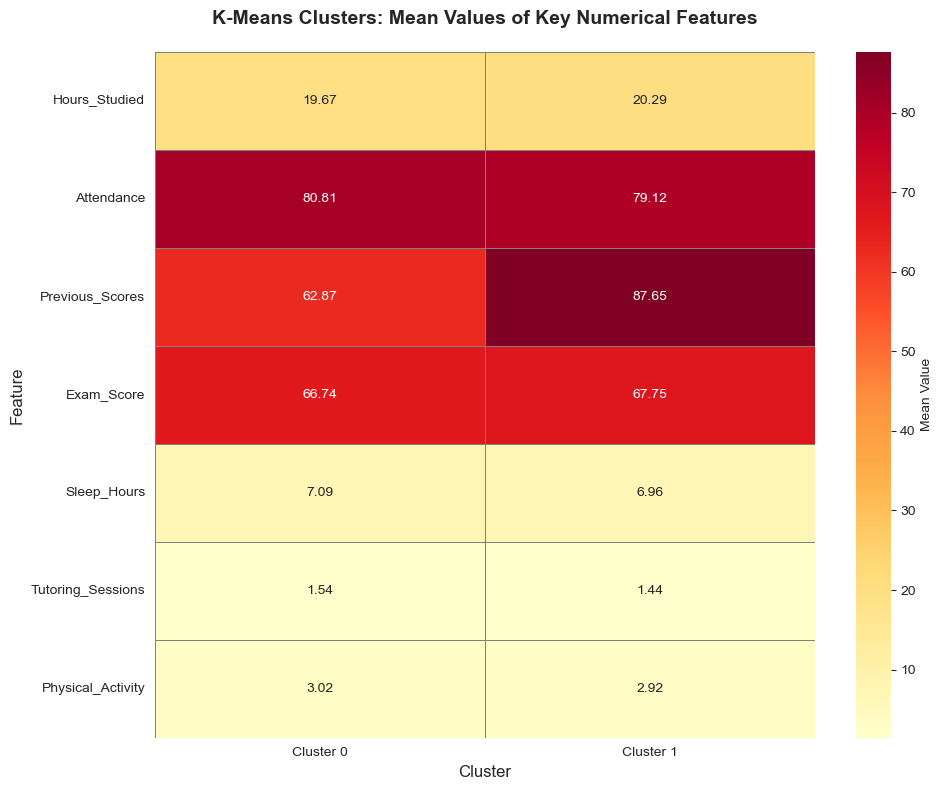

In [169]:
# 2. Heatmap: Key Numerical Features Comparison Across Clusters
key_numerical_features = ['Hours_Studied', 'Attendance', 'Previous_Scores', 'Exam_Score', 
                          'Sleep_Hours', 'Tutoring_Sessions', 'Physical_Activity']

# Calculate mean values for each cluster
cluster_means = pd.DataFrame()
for cluster_id in range(optimal_k):
    cluster_data = df[df['KMeans_Cluster'] == cluster_id]
    cluster_means[f'Cluster {cluster_id}'] = cluster_data[key_numerical_features].mean()

cluster_means.index = key_numerical_features

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cluster_means, annot=True, fmt='.2f', cmap='YlOrRd', 
            cbar_kws={'label': 'Mean Value'}, linewidths=0.5, linecolor='gray')
plt.title('K-Means Clusters: Mean Values of Key Numerical Features', 
         fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()


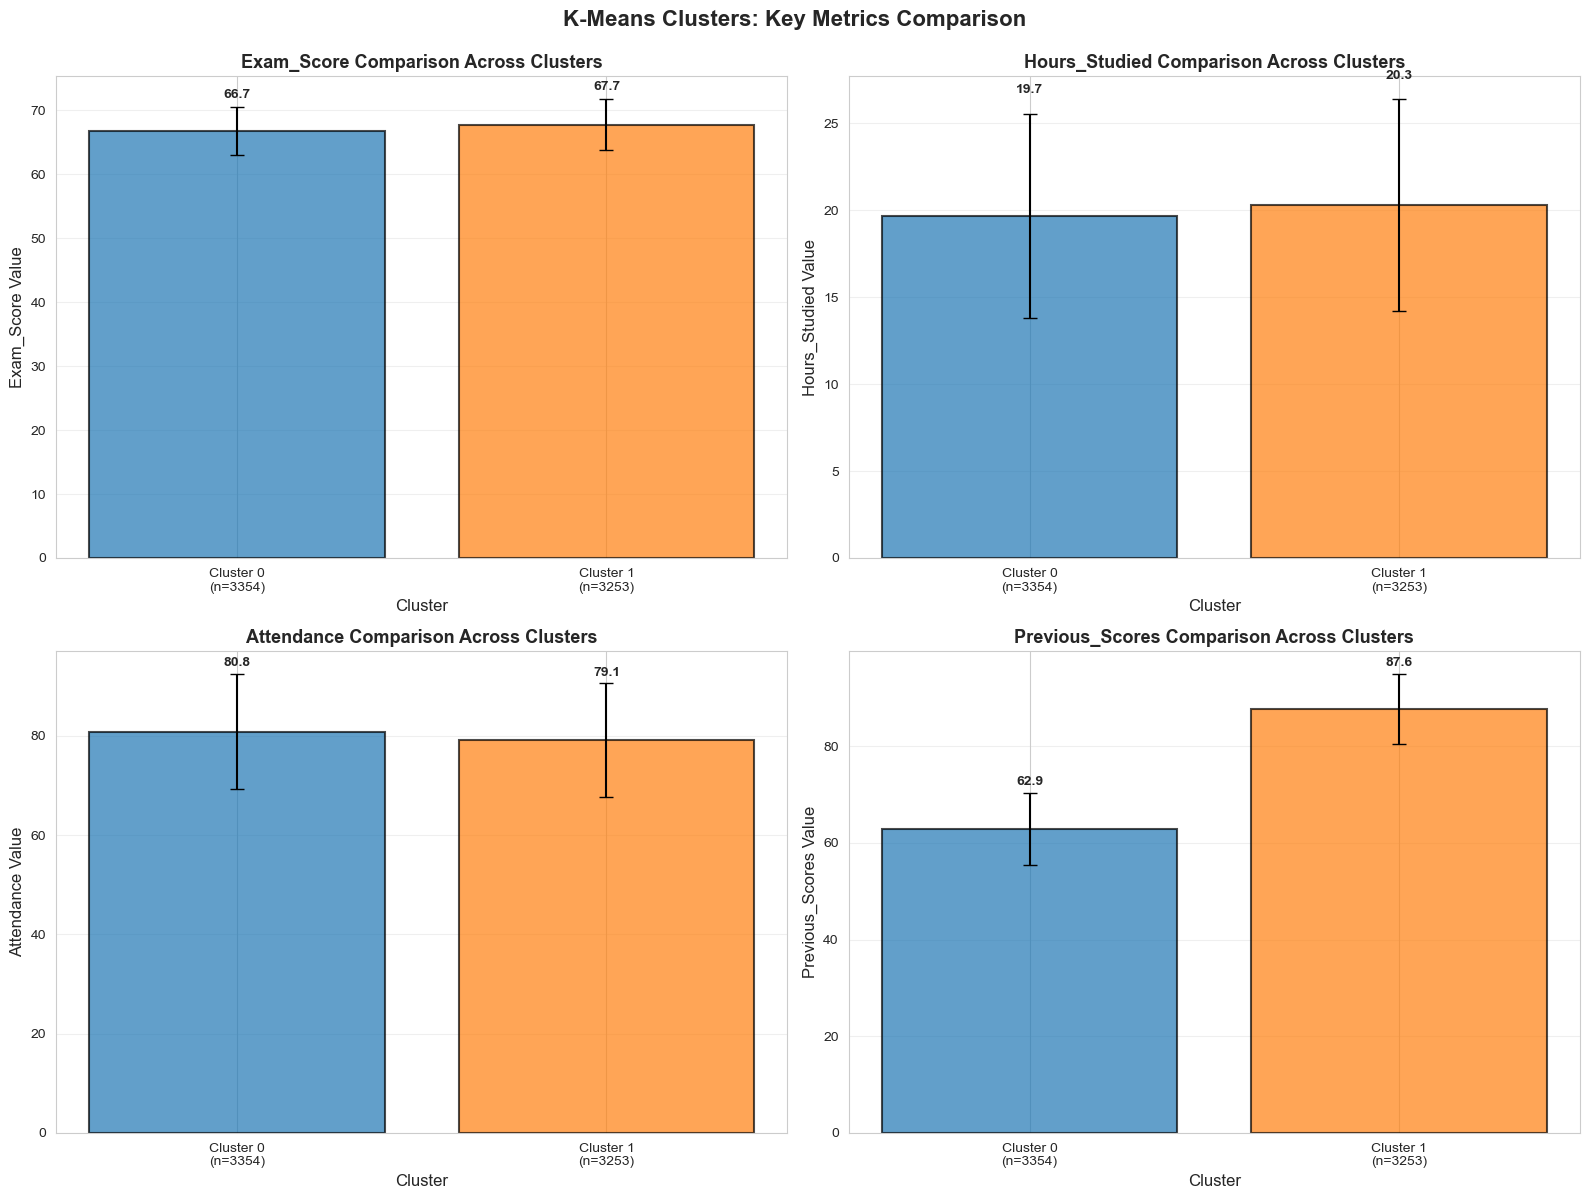

In [170]:
# 3. Side-by-Side Comparison of Key Metrics
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Prepare data for comparison
comparison_features = ['Exam_Score', 'Hours_Studied', 'Attendance', 'Previous_Scores']
colors_list = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for idx, feature in enumerate(comparison_features):
    ax = axes[idx // 2, idx % 2]
    
    # Calculate means and std for each cluster
    cluster_stats = []
    cluster_labels = []
    for cluster_id in range(optimal_k):
        cluster_data = df[df['KMeans_Cluster'] == cluster_id][feature]
        cluster_stats.append({
            'mean': cluster_data.mean(),
            'std': cluster_data.std(),
            'min': cluster_data.min(),
            'max': cluster_data.max()
        })
        cluster_labels.append(f'Cluster {cluster_id}\n(n={len(cluster_data)})')
    
    # Create grouped bar chart
    x = np.arange(optimal_k)
    means = [stat['mean'] for stat in cluster_stats]
    stds = [stat['std'] for stat in cluster_stats]
    
    bars = ax.bar(x, means, yerr=stds, capsize=5, alpha=0.7, 
                  color=colors_list[:optimal_k], edgecolor='black', linewidth=1.5)
    ax.set_xlabel('Cluster', fontsize=12)
    ax.set_ylabel(f'{feature} Value', fontsize=12)
    ax.set_title(f'{feature} Comparison Across Clusters', fontsize=13, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(cluster_labels)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for i, (bar, mean_val) in enumerate(zip(bars, means)):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + stds[i] + 1,
               f'{mean_val:.1f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.suptitle('K-Means Clusters: Key Metrics Comparison', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()


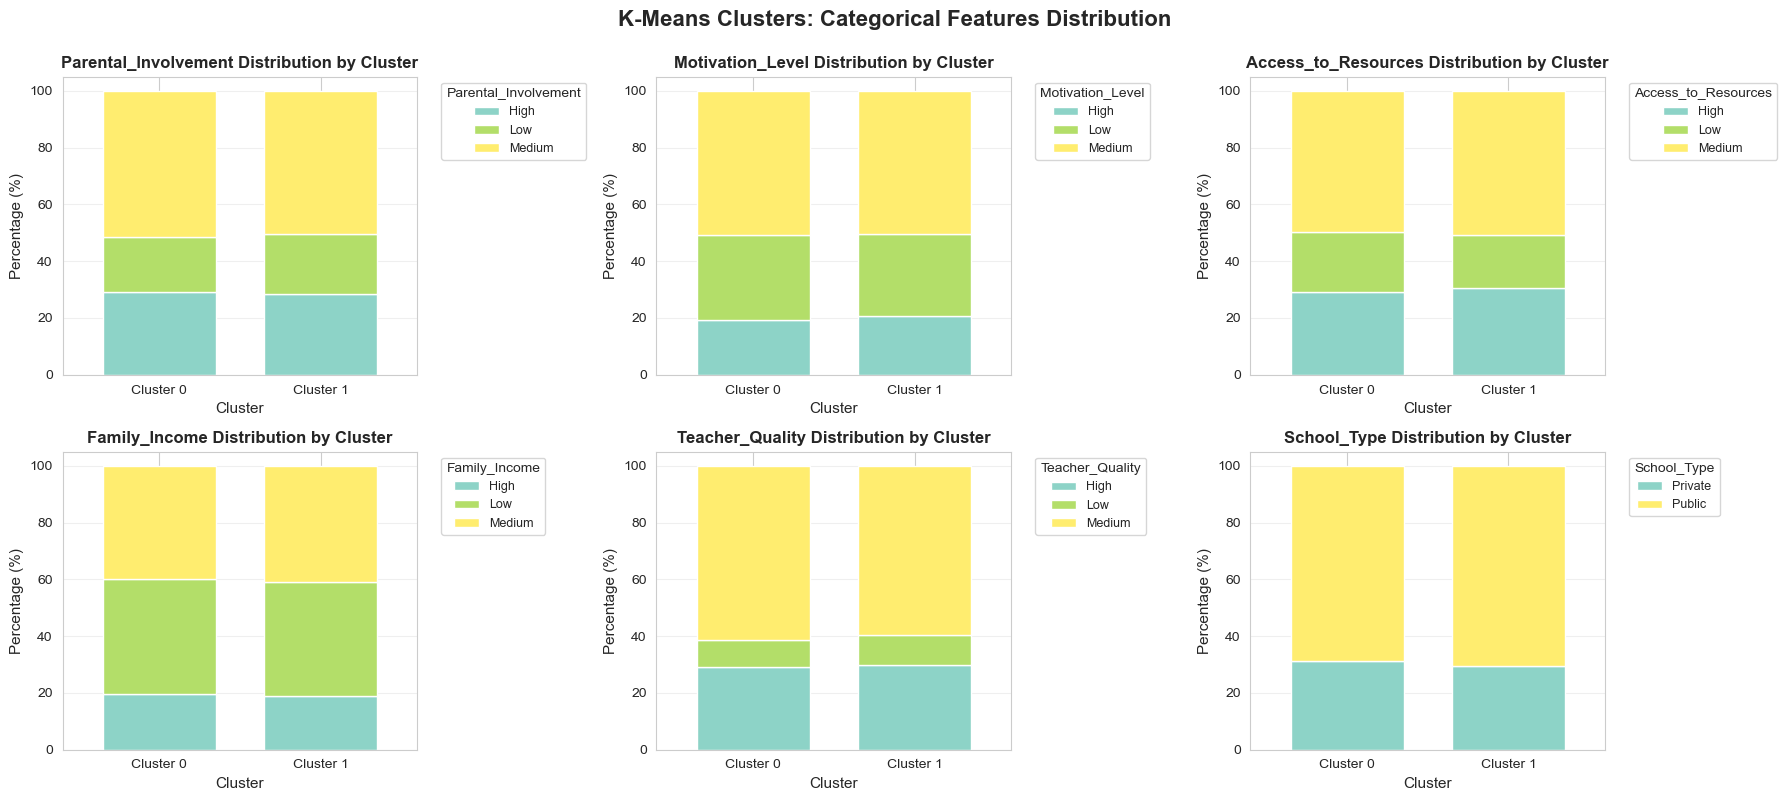

In [171]:
# 4. Categorical Features Distribution Across Clusters
categorical_features = ['Parental_Involvement', 'Motivation_Level', 'Access_to_Resources', 
                        'Family_Income', 'Teacher_Quality', 'School_Type']

# Create subplots for each categorical feature
n_features = len(categorical_features)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4*n_rows))
axes = axes.flatten() if n_features > 1 else [axes]

for idx, feature in enumerate(categorical_features):
    ax = axes[idx]
    
    # Create cross-tabulation
    crosstab = pd.crosstab(df['KMeans_Cluster'], df[feature], normalize='index') * 100
    
    # Create stacked bar chart
    crosstab.plot(kind='bar', stacked=True, ax=ax, colormap='Set3', width=0.7)
    ax.set_title(f'{feature} Distribution by Cluster', fontsize=12, fontweight='bold')
    ax.set_xlabel('Cluster', fontsize=11)
    ax.set_ylabel('Percentage (%)', fontsize=11)
    ax.set_xticklabels([f'Cluster {i}' for i in range(optimal_k)], rotation=0)
    ax.legend(title=feature, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    ax.grid(True, alpha=0.3, axis='y')

# Hide unused subplots
for idx in range(n_features, len(axes)):
    axes[idx].axis('off')

plt.suptitle('K-Means Clusters: Categorical Features Distribution', 
            fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()


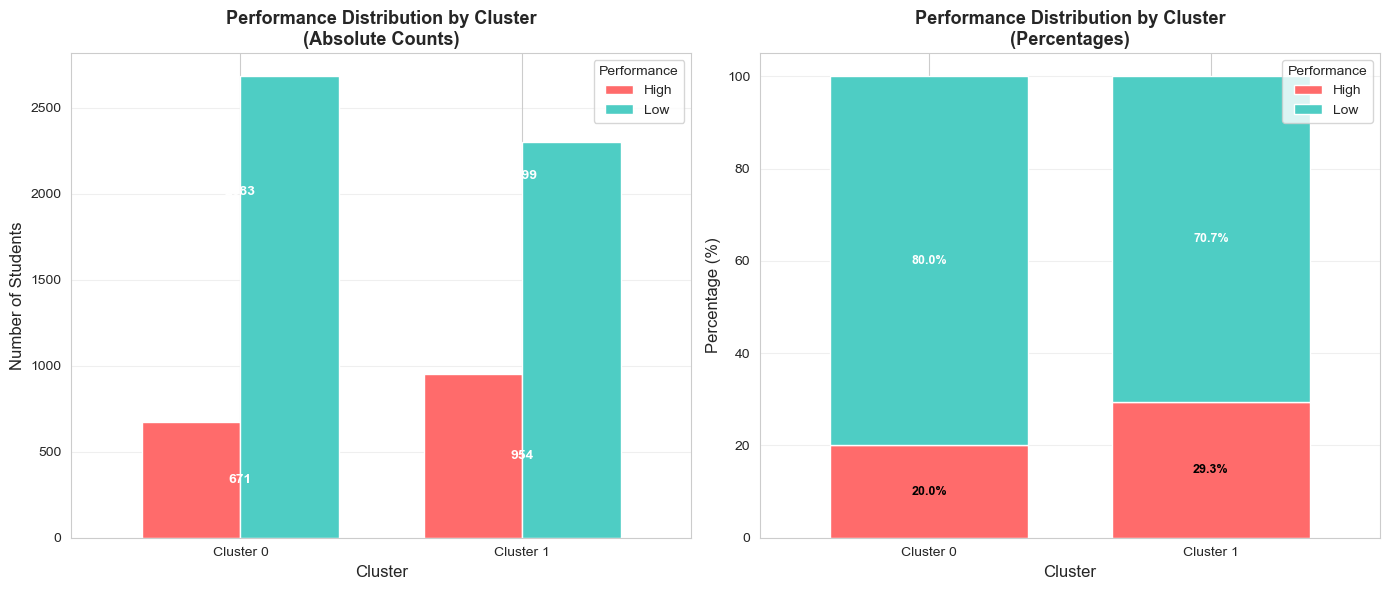

In [172]:
# 5. Performance Distribution by Cluster
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Stacked bar chart
performance_crosstab = pd.crosstab(df['KMeans_Cluster'], df['Performance'])
performance_crosstab_pct = pd.crosstab(df['KMeans_Cluster'], df['Performance'], normalize='index') * 100

# Absolute counts
performance_crosstab.plot(kind='bar', ax=axes[0], color=['#ff6b6b', '#4ecdc4'], width=0.7)
axes[0].set_title('Performance Distribution by Cluster\n(Absolute Counts)', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Cluster', fontsize=12)
axes[0].set_ylabel('Number of Students', fontsize=12)
axes[0].set_xticklabels([f'Cluster {i}' for i in range(optimal_k)], rotation=0)
axes[0].legend(title='Performance', fontsize=10)
axes[0].grid(True, alpha=0.3, axis='y')

# Add value labels
for i in range(optimal_k):
    for j, perf in enumerate(['High', 'Low']):
        value = performance_crosstab.loc[i, perf]
        axes[0].text(i, value/2 if j == 0 else performance_crosstab.loc[i, 'High'] + value/2,
                    f'{value}', ha='center', va='center', fontsize=10, fontweight='bold',
                    color='white' if value > 100 else 'black')

# Percentage
performance_crosstab_pct.plot(kind='bar', stacked=True, ax=axes[1], 
                             color=['#ff6b6b', '#4ecdc4'], width=0.7)
axes[1].set_title('Performance Distribution by Cluster\n(Percentages)', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Cluster', fontsize=12)
axes[1].set_ylabel('Percentage (%)', fontsize=12)
axes[1].set_xticklabels([f'Cluster {i}' for i in range(optimal_k)], rotation=0)
axes[1].legend(title='Performance', fontsize=10)
axes[1].grid(True, alpha=0.3, axis='y')

# Add percentage labels
for i in range(optimal_k):
    y_pos = 0
    for j, perf in enumerate(['High', 'Low']):
        pct = performance_crosstab_pct.loc[i, perf]
        if pct > 5:  # Only label if percentage is significant
            axes[1].text(i, y_pos + pct/2, f'{pct:.1f}%', 
                        ha='center', va='center', fontsize=9, fontweight='bold',
                        color='white' if pct > 30 else 'black')
        y_pos += pct

plt.tight_layout()
plt.show()


## Part 3: Association Rule Mining

In this section, we will:
1. Prepare data for association rule mining
2. Apply Apriori algorithm to find frequent itemsets
3. Generate association rules
4. Analyze and provide insights on discovered patterns


In [173]:
# Installing mlxtend (for association rule mining)
try:
    from mlxtend.frequent_patterns import apriori, association_rules
    from mlxtend.preprocessing import TransactionEncoder
except ImportError:
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "mlxtend"])
    from mlxtend.frequent_patterns import apriori, association_rules
    from mlxtend.preprocessing import TransactionEncoder

# Prepare data for association rule mining
# We'll create binary features from categorical variables and discretize numerical variables

# Select key categorical and numerical features for association rules
association_features = [
    'Parental_Involvement', 'Access_to_Resources', 'Motivation_Level',
    'Family_Income', 'Teacher_Quality', 'School_Type', 'Peer_Influence',
    'Extracurricular_Activities', 'Internet_Access', 'Learning_Disabilities',
    'Parental_Education_Level', 'Distance_from_Home', 'Gender'
]

# Create binary transactions
# For categorical: create binary columns for each value
# For numerical: discretize into bins (High/Medium/Low)

df_assoc = df.copy()

# Discretize numerical features
def discretize_numerical(col, bins=3, labels=['Low', 'Medium', 'High']):
    return pd.cut(df_assoc[col], bins=bins, labels=labels, duplicates='drop')

# Discretize key numerical features
df_assoc['Hours_Studied_Cat'] = discretize_numerical('Hours_Studied')
df_assoc['Attendance_Cat'] = discretize_numerical('Attendance')
df_assoc['Previous_Scores_Cat'] = discretize_numerical('Previous_Scores')
df_assoc['Exam_Score_Cat'] = discretize_numerical('Exam_Score')
df_assoc['Sleep_Hours_Cat'] = discretize_numerical('Sleep_Hours')

# Prepare transaction data
transaction_data = []

for idx, row in df_assoc.iterrows():
    transaction = []
    
    # Add categorical features
    for col in association_features:
        if col in df_assoc.columns:
            transaction.append(f"{col}_{row[col]}")
    
    # Add discretized numerical features
    transaction.append(f"Hours_Studied_{row['Hours_Studied_Cat']}")
    transaction.append(f"Attendance_{row['Attendance_Cat']}")
    transaction.append(f"Previous_Scores_{row['Previous_Scores_Cat']}")
    transaction.append(f"Exam_Score_{row['Exam_Score_Cat']}")
    transaction.append(f"Sleep_Hours_{row['Sleep_Hours_Cat']}")
    
    transaction_data.append(transaction)

print(f"Total transactions: {len(transaction_data)}")
print(f"Sample transaction: {transaction_data[0][:10]}...")


Total transactions: 6607
Sample transaction: ['Parental_Involvement_Low', 'Access_to_Resources_High', 'Motivation_Level_Low', 'Family_Income_Low', 'Teacher_Quality_Medium', 'School_Type_Public', 'Peer_Influence_Positive', 'Extracurricular_Activities_No', 'Internet_Access_Yes', 'Learning_Disabilities_No']...


In [174]:
# Converting transactions to binary matrix
te = TransactionEncoder()
te_ary = te.fit(transaction_data).transform(transaction_data)
df_transactions = pd.DataFrame(te_ary, columns=te.columns_)

print(f"Transaction matrix shape: {df_transactions.shape}")
print(f"Number of unique items: {len(te.columns_)}")
print(f"\nFirst few items: {list(te.columns_[:10])}")


Transaction matrix shape: (6607, 49)
Number of unique items: 49

First few items: ['Access_to_Resources_High', 'Access_to_Resources_Low', 'Access_to_Resources_Medium', 'Attendance_High', 'Attendance_Low', 'Attendance_Medium', 'Distance_from_Home_Far', 'Distance_from_Home_Moderate', 'Distance_from_Home_Near', 'Exam_Score_High']


In [175]:
# Apply Apriori algorithm to find frequent itemsets
# Try different minimum support values
min_support_values = [0.1, 0.15, 0.2, 0.25]

print("Finding frequent itemsets with Apriori algorithm...")
print("-"*60)

frequent_itemsets_list = {}

for min_sup in min_support_values:
    frequent_itemsets = apriori(df_transactions, min_support=min_sup, use_colnames=True, max_len=3)
    frequent_itemsets_list[min_sup] = frequent_itemsets
    print(f"\nMin Support = {min_sup}:")
    print(f"  Number of frequent itemsets: {len(frequent_itemsets)}")
    if len(frequent_itemsets) > 0:
        print(f"  Top 5 itemsets by support:")
        print(frequent_itemsets.nlargest(5, 'support')[['support', 'itemsets']].to_string())

# Use the best min_support (one that gives reasonable number of itemsets)
best_min_support = 0.15
frequent_itemsets = frequent_itemsets_list[best_min_support]

print(f"\nUsing min_support = {best_min_support}")
print(f"Total frequent itemsets found: {len(frequent_itemsets)}")


Finding frequent itemsets with Apriori algorithm...
------------------------------------------------------------

Min Support = 0.1:
  Number of frequent itemsets: 2861
  Top 5 itemsets by support:
      support                                         itemsets
19   0.924474                            (Internet_Access_Yes)
20   0.894809                       (Learning_Disabilities_No)
8    0.836083                                 (Exam_Score_Low)
464  0.826699  (Internet_Access_Yes, Learning_Disabilities_No)
253  0.768276            (Internet_Access_Yes, Exam_Score_Low)

Min Support = 0.15:
  Number of frequent itemsets: 1377
  Top 5 itemsets by support:
      support                                         itemsets
19   0.924474                            (Internet_Access_Yes)
20   0.894809                       (Learning_Disabilities_No)
8    0.836083                                 (Exam_Score_Low)
315  0.826699  (Internet_Access_Yes, Learning_Disabilities_No)
171  0.768276          

In [176]:
# Generate association rules
print("\nGenerating association rules...")
print("-"*60)

# Generate rules with different metrics
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)

print(f"Total rules generated: {len(rules)}")

if len(rules) > 0:
    # Sort by confidence and lift
    rules_sorted = rules.sort_values(['confidence', 'lift'], ascending=[False, False])
    
    print(f"\nTop 10 Rules by Confidence:")
    print(rules_sorted[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10).to_string())
    
    # Filter high-quality rules (high confidence and lift > 1)
    high_quality_rules = rules[(rules['confidence'] >= 0.6) & (rules['lift'] > 1.0)]
    print(f"\nHigh-quality rules (confidence >= 0.6, lift > 1.0): {len(high_quality_rules)}")
    
    if len(high_quality_rules) > 0:
        print(f"\nTop High-Quality Rules:")
        print(high_quality_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10).to_string())
else:
    print("No rules found with the current thresholds. Trying lower confidence threshold...")
    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.3)
    print(f"Rules with confidence >= 0.3: {len(rules)}")
    if len(rules) > 0:
        rules_sorted = rules.sort_values(['confidence', 'lift'], ascending=[False, False])
        print(f"\nTop 10 Rules:")
        print(rules_sorted[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10).to_string())



Generating association rules...
------------------------------------------------------------
Total rules generated: 3112

Top 10 Rules by Confidence:
                                                antecedents       consequents   support  confidence      lift
789                  (Attendance_Low, Hours_Studied_Medium)  (Exam_Score_Low)  0.238232    0.988073  1.181788
472            (Access_to_Resources_Medium, Attendance_Low)  (Exam_Score_Low)  0.170577    0.987730  1.181378
799  (Parental_Education_Level_High School, Attendance_Low)  (Exam_Score_Low)  0.172696    0.985320  1.178495
802           (Parental_Involvement_Medium, Attendance_Low)  (Exam_Score_Low)  0.170879    0.984307  1.177284
795              (Attendance_Low, Learning_Disabilities_No)  (Exam_Score_Low)  0.295142    0.983359  1.176150
797               (Motivation_Level_Medium, Attendance_Low)  (Exam_Score_Low)  0.167096    0.983081  1.175818
785                           (Gender_Male, Attendance_Low)  (Exam_Score_Low)  

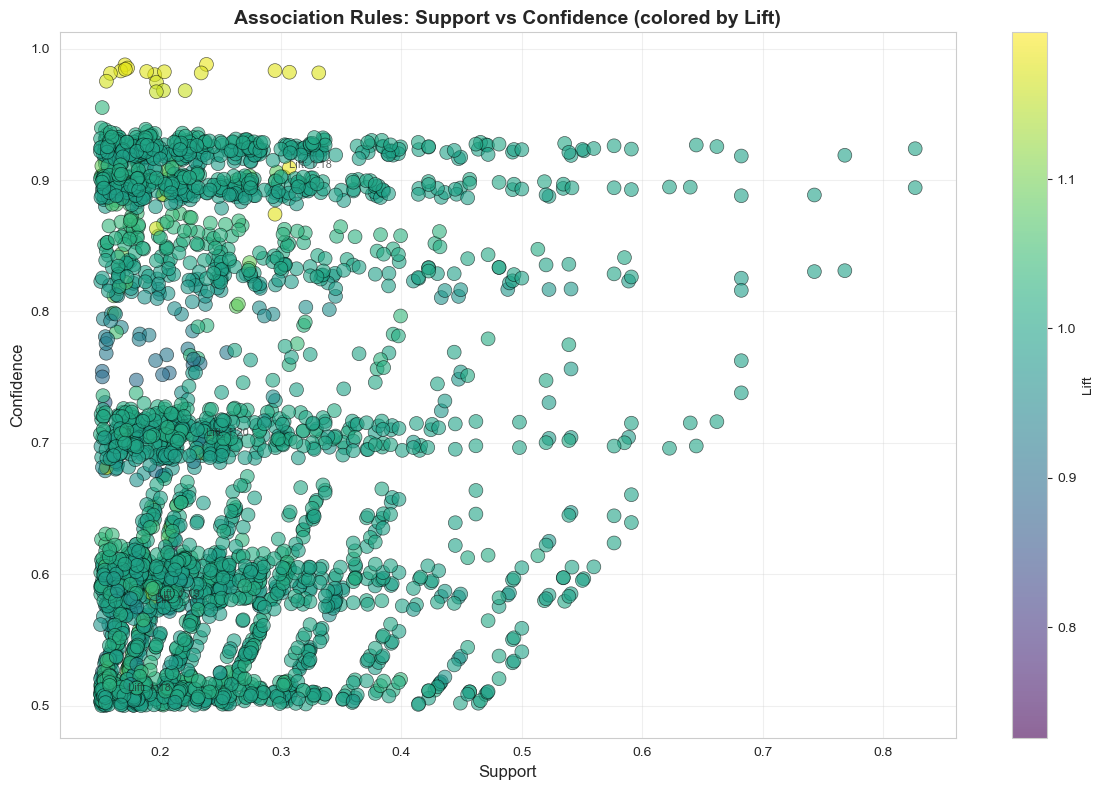

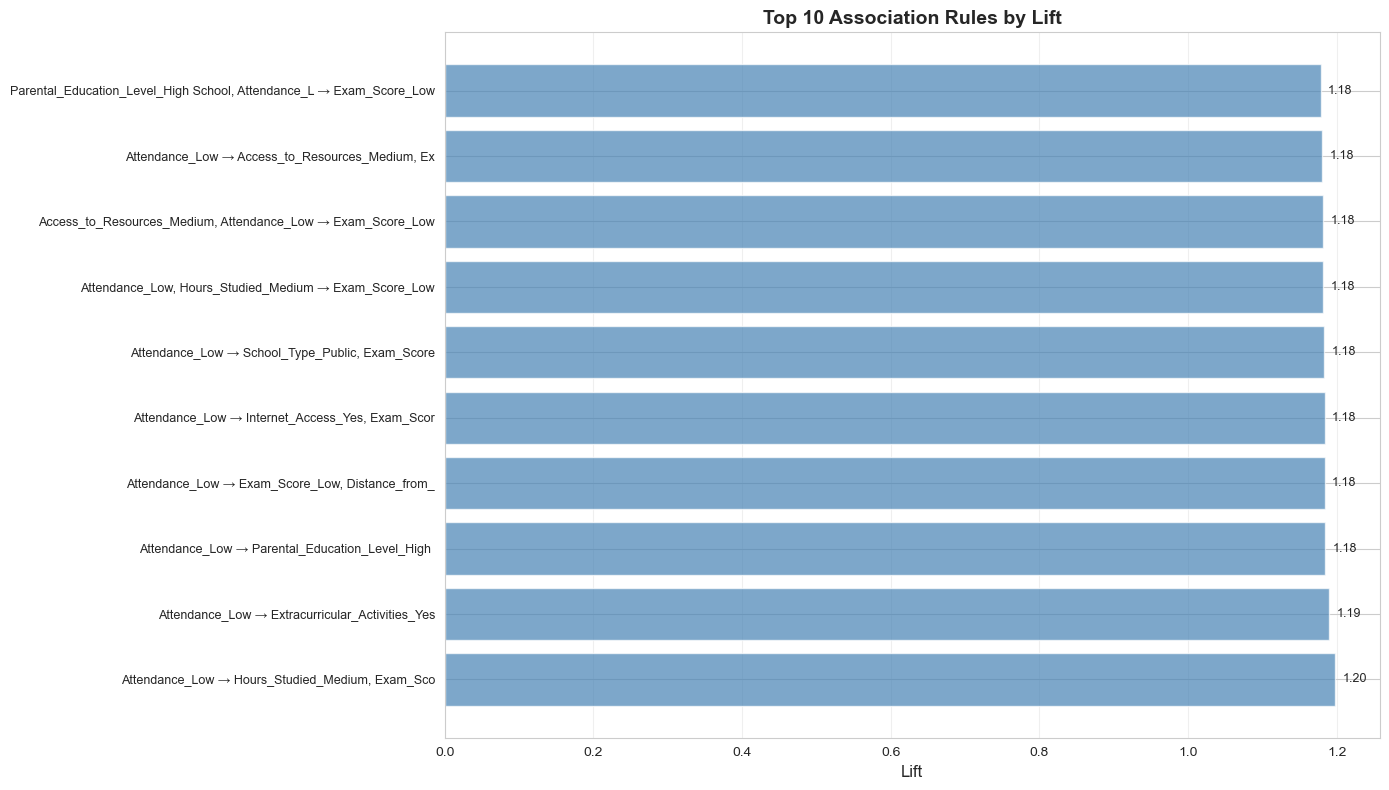

In [177]:
# Visualizing association rules
if len(rules) > 0:
    # Scatter plot: Support vs Confidence
    plt.figure(figsize=(12, 8))
    
    scatter = plt.scatter(rules['support'], rules['confidence'], 
                         c=rules['lift'], cmap='viridis', 
                         s=100, alpha=0.6, edgecolors='black', linewidth=0.5)
    plt.colorbar(scatter, label='Lift')
    plt.xlabel('Support', fontsize=12)
    plt.ylabel('Confidence', fontsize=12)
    plt.title('Association Rules: Support vs Confidence (colored by Lift)', 
             fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    
    # Annotate top rules
    if len(rules) > 0:
        top_rules = rules.nlargest(5, 'lift')
        for idx, rule in top_rules.iterrows():
            plt.annotate(f"Lift: {rule['lift']:.2f}", 
                        (rule['support'], rule['confidence']),
                        fontsize=8, alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    # Bar plot of top rules by lift
    if len(rules) > 0:
        top_rules = rules.nlargest(10, 'lift')
        fig, ax = plt.subplots(figsize=(14, 8))
        
        # Create rule labels
        rule_labels = []
        for idx, rule in top_rules.iterrows():
            antecedents = ', '.join(list(rule['antecedents']))[:50]
            consequents = ', '.join(list(rule['consequents']))[:30]
            rule_labels.append(f"{antecedents} → {consequents}")
        
        y_pos = np.arange(len(rule_labels))
        bars = ax.barh(y_pos, top_rules['lift'], color='steelblue', alpha=0.7)
        ax.set_yticks(y_pos)
        ax.set_yticklabels(rule_labels, fontsize=9)
        ax.set_xlabel('Lift', fontsize=12)
        ax.set_title('Top 10 Association Rules by Lift', fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3, axis='x')
        
        # Add value labels on bars
        for i, (bar, lift) in enumerate(zip(bars, top_rules['lift'])):
            ax.text(lift + 0.01, bar.get_y() + bar.get_height()/2, 
                   f'{lift:.2f}', va='center', fontsize=9)
        
        plt.tight_layout()
        plt.show()


### Insights from above data
The association rule analysis highlights key patterns linking student attributes to exam performance. The most consistent finding is that low attendance strongly predicts low exam scores, often in combination with medium study hours, parental involvement, or teacher quality, with confidence values above 0.98. Other high-quality rules indicate that access to resources influences learning outcomes, where low access is associated with low scores and high access with no learning disabilities. Additionally, factors such as study hours, school type, teacher quality, and proximity to school appear in several rules, suggesting they moderately affect performance. Overall, these rules reveal that attendance and access to resources are the strongest drivers of exam outcomes, while other factors like motivation, parental involvement, and school-related conditions also contribute but to a lesser extent.

## Provide insights into how these discovered patterns can be applied in a real-world context.


### Classification Insights: Predictive Intervention

The analysis revealed that the Tuned Naïve Bayes model achieved the highest performance among classification models, with an accuracy of 0.9281 and an F1 score of 0.9536. This makes it a robust tool for predicting whether a student is likely to achieve a high or low exam score. By applying this model to historical or current student data, such as previous scores, attendance, and demographics, educational institutions can identify students at high risk of low performance long before exams occur. This predictive capability enables targeted interventions, allowing schools to prioritize resources such as remedial classes, counseling, tutoring, or parent engagement. By shifting from reactive to proactive support, institutions can maximize the effectiveness of their academic assistance programs.

### Clustering Insights: Differentiated Support Groups

K-Means clustering revealed two distinct student groups primarily differentiated by previous scores and family income, indicating a strong link between socioeconomic factors and academic performance.

Cluster 0 (Lower Previous Scores, Low Family Income): This group contains the lowest percentage of high performers (20%). Interventions for these students could focus on addressing foundational skill gaps and providing additional material or financial resources.

Cluster 1 (Higher Previous Scores, Medium Family Income): While performing better overall, 70.7% of students in this cluster still score low. Interventions here may target advanced subject enrichment, motivation, or strategies to maintain academic momentum.

These clusters provide a clear, data-driven basis for resource allocation, enabling the school to distribute scholarships, tutoring slots, or counseling time where it is needed most, ensuring equitable support.

### Association Rule Insights: Causal Factors and Policy
Association rule mining highlighted strong conditional relationships between various factors and student performance outcomes.

Risk Mitigation: High-confidence rules, such as Attendance_Low ⇒ Exam_Score_Low (98.16% confidence, 1.17 lift), indicate nearly certain predictors of poor performance. This underscores the importance of attendance as a non-negotiable factor in academic success. Schools should implement or strengthen policies to monitor attendance closely, such as mandatory check-ins or automated alerts for parents and counselors.

Resource Management: Rules like Access_to_Resources_Low ⇒ Exam_Score_Low (91.16% confidence) and Access_to_Resources_Medium ⇒ Exam_Score_Low (85.18% confidence) reveal that inadequate access to resources is a major barrier. The institution should audit and enhance resource accessibility, including library hours, computer labs, and textbook loan programs, particularly for students with reported low access. Interestingly, the rule Access_to_Resources_Low ⇒ Internet_Access_Yes (93.22% confidence) suggests that “low resources” may not mean a lack of internet but a deficiency in other critical tools, allowing the school to refine its understanding of resource gaps.